In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

In [2]:
from general_functions import *

In [3]:
pd.set_option('display.max_columns', None)


# WSRL

In [4]:
#define relative paths
waterschap = 'WSRL'
data_path = "../../Data_preprocessed/Waterschappen/WSRL"
output_gpkg_path = "../../Data_postprocessed/Waterschappen/WSRL"

In [5]:
#WSRL has delivered the data per catchment. Loop through each catchment, and concat all data to a single dictionary
WSRL = {}

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.gpkg'):
            gpkg_path = os.path.join(root, file)
            
            if WSRL == {}:
                WSRL = read_gpkg_layers(gpkg_path = gpkg_path,
                                         variables = ['Stuw',
                                                      'Gemaal',
                                                      'Hydroobject',
                                                      'Duikersifonhevel'])   
            else:
                temp_WSRL = read_gpkg_layers(gpkg_path = gpkg_path,
                                             variables = ['Stuw',
                                                          'Gemaal',
                                                          'Hydroobject',
                                                          'Duikersifonhevel'])   
                for variable in WSRL.keys():
                    WSRL[variable] = pd.concat([WSRL[variable], temp_WSRL[variable]]).reset_index(drop=True)


Additional data is given in another gpkg, which includes the peilgebieden

In [7]:
gdb_path = r"..\..\Data_preprocessed\Waterschappen\WSRL\OverigeGegevens.gdb"
WSRL_gdb = read_gpkg_layers(gpkg_path = gdb_path,
                            variables = ['PeilgebiedenPraktijk'])

#add the gdb to the dict
# WSRL['peilgebiedafwijking'] = WSRL_gdb['Peilafwijkingen']
WSRL['peilgebiedpraktijk'] = WSRL_gdb['PeilgebiedenPraktijk']

In [8]:
#change names
WSRL['stuw'] = WSRL.pop('Stuw')
WSRL['gemaal'] = WSRL.pop('Gemaal')
WSRL['hydroobject'] = WSRL.pop('Hydroobject')
WSRL['duikersifonhevel'] = WSRL.pop('Duikersifonhevel')

### Adjust column names

In [9]:
#add gemaal information
WSRL['peilgebiedpraktijk']['waterhoogte'] = np.nan
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'seizoensgebonden', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'flexibel', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'natuurlijk', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'vast', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['VASTPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'streef', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['STREEFPEIL'], inplace=True)

#niet elke kolom is ingevuld met de paren die je zou verwachten. Vul voor de ontbrekende waarden de volgende waarden in:
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['STREEFPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['VASTPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['MIN_PEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['WINTERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['MAX_PEIL'], inplace=True)


In [12]:
#Add gemaal information
#determine aanvoer en afvoer gemalen
WSRL['gemaal']['func_aanvoer'], WSRL['gemaal']['func_afvoer'], WSRL['gemaal']['func_circulatie']  = False, False, False #default is False
WSRL['gemaal']['functiegemaal'] = WSRL['gemaal']['naam'].astype(str) 


WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Afvoer|Onbekend|Af-|Onderbemaling'), 'func_afvoer'] = True
WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Aanvoer|Opmaling'), 'func_aanvoer'] = True
WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Doorspoelgemaal'), 'func_circulatie'] = True
WSRL['gemaal'].loc[(WSRL['gemaal'].func_afvoer == False) &
                       (WSRL['gemaal'].func_aanvoer == False) &
                       (WSRL['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [13]:
#discard irrelevant data of WSRL, and create a uniform dataset compared to the other waterschappen
WSRL['stuw'] = WSRL['stuw'][['code', 'globalid', 'nen3610id', 'geometry']]
WSRL['gemaal'] = WSRL['gemaal'][['code', 'globalid', 'nen3610id', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
WSRL['hydroobject'] = WSRL['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]
WSRL['duikersifonhevel'] = WSRL['duikersifonhevel'][['code', 'globalid', 'nen3610id', 'geometry']]


In [14]:
# gpd.overlay(WSRL['peilgebiedpraktijk'], WSRL['peilgebiedafwijking'], how='union', keep_geom_type=False).to_file('WSRL_kan_weg.gpkg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


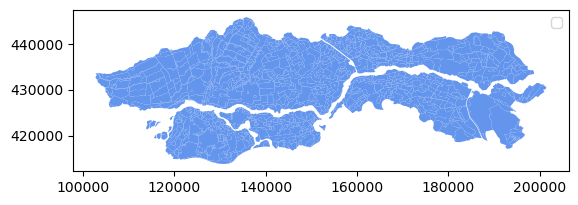

In [15]:
fig, ax = plt.subplots()
WSRL['peilgebiedpraktijk'].plot(ax=ax, color='cornflowerblue', label = 'Peilgebiedpraktijk')
# WSRL['peilgebiedafwijking'].plot(ax=ax, color='blue', label = 'Peilgebiedafwijking')
ax.legend()
plt.show()

In [16]:
def intersect_using_spatial_index(peilgebied_praktijk, peilgebied_afwijking, check):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    peilgebied_praktijk_sindex = peilgebied_praktijk.sindex
    possible_matches_index = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in peilgebied_afwijking.itertuples():
        bounds = other.geometry.bounds
        c = list(peilgebied_praktijk_sindex.intersection(bounds))
        possible_matches_index += c
    
    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = peilgebied_praktijk.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    overlapping_pg_praktijk = possible_matches.loc[possible_matches.intersects(peilgebied_afwijking.unary_union)] #the entire peilgebied praktijk polygons
    
    #remove the peilgebied afwijking from the peilgebied praktijk
    intersection = gpd.overlay(overlapping_pg_praktijk, peilgebied_afwijking, how='intersection')
    overlapping_updated = gpd.overlay(peilgebied_praktijk, intersection, how='symmetric_difference') #check of het difference of symmetrical difference moet zijn!#remove the difference between pg_praktijk and pg_afwijking
    peilgebied = overlapping_updated.append(intersection, ignore_index=True) #add the removed difference, but now only the intersected part of pg_afwijking

    
    if check == True:
        peilgebied_praktijk.to_file('Checks/Rivierenland/peilgebied_praktijk.gpkg', driver='GPKG')
        peilgebied_afwijking.to_file('Checks/Rivierenland/peilgebied_afwijking.gpkg', driver='GPKG')

        intersection.to_file('Checks/Rivierenland/intersection.gpkg', driver='GPKG')
        overlapping_updated.to_file('Checks/Rivierenland/overlapping_updated.gpkg', driver='GPKG')
        peilgebied.to_file('Checks/Rivierenland/peilgebied.gpkg', driver='GPKG')
    
    return peilgebied

In [17]:
# peilgebied = intersect_using_spatial_index(peilgebied_praktijk = WSRL['peilgebiedpraktijk'], 
#                                            peilgebied_afwijking = WSRL['peilgebiedafwijking'],
#                                            check = False)
peilgebied = WSRL['peilgebiedpraktijk']

In [18]:
# WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'][['ZOMERPEIL', 'WINTERPEIL', 'MIN_PEIL', 'MAX_PEIL', 'STREEFPEIL', 'VASTPEIL', 'TYPE_PEILBEHEER', 'geometry']]
# peilgebied['waterhoogte'] = np.nan

# for fill_column in ['ZOMERPEIL', 'STREEFPEIL', 'VASTPEIL', 'MAX_PEIL', 'MIN_PEIL', 'WINTERPEIL']:
#     peilgebied.waterhoogte.fillna(value = peilgebied[fill_column], inplace=True)
                                                  
# WSRL['peilgebiedpraktijk'].waterhoogte.fillna(value=WSRL['peilgebiedpraktijk'][['ZOMERPEIL', 'STREEFPEIL', 'VASTPEIL', 'MAX_PEIL', 'MIN_PEIL']])

<AxesSubplot:>

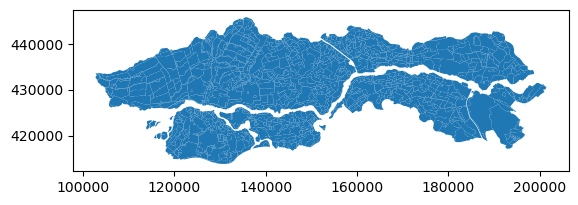

In [19]:
#store the ontbrekende_streefpeilen to a gpkg, check validity
ontbrekende_streefpeilen = peilgebied[peilgebied.waterhoogte.isna()]
# ontbrekende_streefpeilen.to_file('Checks/Rivierenland/peilgebieden_zonder_streefpeil.gpkg', driver='GPKG')
peilgebied.plot()

In [20]:
peilgebied['CODE_0'] = peilgebied.CODE #change names for later purposes
peilgebied.CODE = np.nan

#add and fill the final columns
columns_to_check = ['CODE_0']

for fill_column in ['CODE_0']:
    peilgebied.CODE.fillna(value = peilgebied[fill_column], inplace=True)

peilgebied['globalid'] = peilgebied.index.astype(str)
peilgebied['nen3610id'] = 'dummy_nen3610id_peilgebied_' + peilgebied.index.astype(str)

#create streefpeil key
WSRL['streefpeil'] = peilgebied[['waterhoogte', 'globalid']]
WSRL['streefpeil']['geometry'] = np.nan
WSRL['streefpeil'] = gpd.GeoDataFrame(WSRL['streefpeil'])

#only select the relevant columns
peilgebied = peilgebied[['CODE', 'globalid', 'nen3610id', 'geometry']]
WSRL['peilgebied'] = peilgebied #add to the dict

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_27676\1047803125.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSRL['streefpeil']['geometry'] = np.nan


In [21]:
#discard irrelvant data
variables = ['peilgebiedpraktijk','peilgebiedafwijking']

for variable in variables:
    if str(variable) in WSRL:
        del WSRL[variable]

### Check for the correct keys and columns

In [22]:
show_layers_and_columns(waterschap = WSRL)

stuw
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'nen3610id' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  None

peilgebied
['CODE' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992



### Store data

In [23]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = WSRL, 
           output_gpkg_path = output_gpkg_path + '/WSRL')
